In [1]:
import enoki as ek
import numpy as np
import matplotlib.pyplot as plt
import mitsuba
mitsuba.set_variant('gpu_autodiff_acoustic')
from mitsuba.python.util import traverse
import time
from tqdm.notebook import trange, tqdm

2021-06-05 19:59:34 INFO main [optix_api.cpp:56] Dynamic loading of the Optix library ..

In [2]:
def estimate_detector_radius(room_dimensions, N):
    return ((15 * room_dimensions[0] * room_dimensions[1] * room_dimensions[2]) / (2 * np.pi * N))**(1/2)

def estimate_max_depth(box_dimensions, max_time, boost=1):
    max_box_distance = np.linalg.norm(box_dimensions) / 2
    max_box_time = max_box_distance / 343
    max_depth_estimate = np.ceil(max_time / max_box_time * boost).astype(int) 
    return max_depth_estimate

def make_shoebox_scene(emitter_pos, sensor_pos, box_dimensions, radius, max_time, time_steps, 
                       spp, bins, rfilter, max_depth, samples_per_pass, scattering,absorption, hide_sensor=True):
    
    from mitsuba.core import ScalarTransform4f

    def transform(scale=None, rotate=None, translate=None):
        if translate is None:
            translate = [0, 0, 0]
        if scale is None:
            scale = [1, 1, 1]
        if rotate is None:
            rotate = ([0, 0, 0], 0)

        a = ScalarTransform4f.scale(scale)
        b = ScalarTransform4f.rotate(*rotate)
        c = ScalarTransform4f.translate(translate)
        return c * b * a

    global_translation = transform(translate=np.array(box_dimensions) / 2)

    scene = {
        "type": "scene",
        "bsdf_neutral": {
            "type": "acousticbsdf",
            "scattering": {
                "type": "spectrum",
                "value": scattering
            },
            "absorption": {
                "type": "spectrum",
                "value": absorption
            }
        },
        "emitter_shape": {
            "id": "emitter",
            "type": "sphere",
            "radius": radius,
            "to_world": transform(translate=emitter_pos),
            "emitter": {
                "type": "area",
                "radiance": {
                    "type": "uniform",
                    "value": 1
                }
            }
        },
        "sensor": {
            "type": "microphone",
            "to_world": transform(translate=sensor_pos),
            "sampler": {
                "type": "independent",
                "sample_count": spp
            },
            "myfilm": {
                "type": "tape",
                "time_steps": time_steps,
                "wav_bins": len(bins),
                "rfilter": rfilter
            }  
        },
        "shoebox": {
            "id": "shoebox",
            "type": "obj",
            "filename": "../resources/cuberoom.obj",
            "bsdf": {
                "type": "ref",
                "id": "bsdf_neutral"
            },
            "to_world": global_translation * transform(scale=np.array(box_dimensions) / 2)
        },
        "integrator": {
            "type": "acousticpath",
            "max_depth": int(max_depth),
            "max_time": max_time,
            "wavelength_bins": ','.join(str(x) for x in bins),
            "samples_per_pass": samples_per_pass
        }
    }
    return scene

def get_vals(data, size, copy=False):
    return np.array(data, copy=copy).reshape(size)


In [3]:
from mitsuba.core.xml import load_string, load_dict

bins = [1, 7, 17]
absorption = list(zip(bins, [0.55, 0.08, 0.25]))

config = {
    "bins": bins,
    "absorption": absorption,
    "scattering": 0.1,
    "max_time": 1,
    "time_steps": 10,
    "spp": 1000,
    "samples_per_pass": 1000,
    "box_dimensions": [25, 12, 7],
    "emitter_pos": [20, 7, 2],
    "sensor_pos": [9, 6, 1],
    "radius": 1.,  #estimate_detector_radius(box_dimensions, spp)
    "max_depth": 132, #estimate_max_depth(0.9),
    "rfilter": {
        "type": "gaussian",
        "stddev": 0.5
    }
}

scene_dict = make_shoebox_scene(**config)
scene = load_dict(scene_dict)
size = scene.sensors()[0].film().size()

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/acousticbsdf.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/uniform.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/irregular.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/sphere.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/area.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/d65.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/regular.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/diffuse.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/microphone.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/independent.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/tape.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/gaussian.so" ..

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/obj.so" ..

2021-06-05 19:59:35 DEBUG main [OBJMesh] Loading mesh from "cuberoom.obj" ..

2021-06-05 19:59:35 DEBUG main [OBJMesh] "cuberoom.obj": read 12 faces, 24 vertices (912 B in 0ms)

2021-06-05 19:59:35 INFO main [PluginManager] Loading plugin "plugins/acousticpath.so" ..

2021-06-05 19:59:35 INFO main [Scene] Building scene in OptiX ..

ParameterMap[
  * AcousticBSDF.scattering.value,
  * AcousticBSDF.absorption.wavelengths,
  * AcousticBSDF.absorption.values,
    emitter.to_world,
  * emitter.bsdf.reflectance.value,
  * emitter.emitter.radiance.value,
    Microphone.shutter_open,
    Microphone.shutter_open_time,
    shoebox.to_world,
    shoebox.vertex_count,
    shoebox.face_count,
  * shoebox.faces_buf,
  * shoebox.vertex_positions_buf,
  * shoebox.vertex_normals_buf,
  * shoebox.vertex_texcoords_buf,
]
[0.55, 0.08, 0.25]


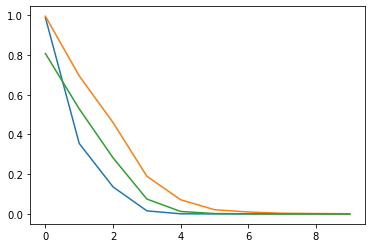

In [4]:
from mitsuba.core import Spectrum, Float

diff_param = 'AcousticBSDF.absorption.values'

params = traverse(scene)
print(params)
print(params[diff_param])
params.keep([diff_param])
param_ref = Spectrum(params[diff_param])

from mitsuba.python.autodiff import render
hist_ref = render(scene, spp=None)
plt.plot(get_vals(hist_ref, size))
plt.show()

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class OptimizationPlot:
    def __init__(self, name, bins, target, max_time=1.0):
        self._error = []
        self._bins = bins
        self._max_time = max_time
        
        X = np.linspace(0, len(self._bins), target.shape[1])
        Y = np.linspace(0, self._max_time, target.shape[0])
        X, Y = np.meshgrid(X, Y)
    
        self._fig = go.FigureWidget(make_subplots(rows=1, cols=2, subplot_titles=("Spectogram", "Error"), specs=[[{"type": "surface"}, {"type": "scatter"}]]))
        
        self._fig.update_layout(title=name, scene_aspectmode='cube')

        self._fig.add_surface(row=1, col=1, showscale=False, name="current")
        self._fig.add_surface(row=1, col=1, showscale=False, opacity=0.2, colorscale=['blue', 'blue'], name="target")
        self._fig.add_scatter(row=1, col=2)
                
        self._fig.data[0].x = X
        self._fig.data[0].y = Y
        self._fig.data[1].x = X
        self._fig.data[1].y = Y
        self._fig.data[1].z = target

    def plot_optimization_state(self, current, err_ref):
        self._error.append(err_ref)
        self._fig.data[0].z = current

        self._fig.data[2].y = self._error
        
        time.sleep(0.1)

    @property
    def error(self):
        return self._error
    
    def show(self):
        return self._fig

In [7]:
iterations = 100
np_hist_ref = get_vals(hist_ref, size, copy=True)

def mse(a, b):
    return ek.hsum(ek.sqr(a - b)) / len(hist)

def mse_decay(a, b):
    return ek.hsum(ek.sqr(a - b) * ek.exp(-Float.linspace(0, 5, len(hist)))) / len(hist)

err_func = mse
params[diff_param] = [0.1] * len(bins)

# Construct an optimizer that will adjust the parameters 'params'
from mitsuba.python.autodiff import Adam, SGD
opt = SGD(params, lr=.2)

opt_plot = OptimizationPlot(err_func.__name__, config['bins'], np_hist_ref, config['max_time'])
opt_plot.show()

FigureWidget({
    'data': [{'name': 'current',
              'scene': 'scene',
              'showscale': Fal…

In [8]:
pbar = tqdm(range(iterations), desc='iterations')

for it in pbar:
    # Perform a differentiable rendering of the scene
    hist = render(scene, optimizer=opt, unbiased=False, spp=None)

    np_hist = get_vals(hist, size, copy=True)

    # Objective: MSE between 'hist' and 'hist_ref'
    ob_val = err_func(hist, hist_ref)

    # Back-propagate errors to input parameters
    ek.backward(ob_val)

    # Optimizer: take a gradient step
    opt.step()

    # Compute error
    err_ref = np.sum(np.square(param_ref - params[diff_param]))
    
    pbar.set_postfix({'absorption': params[diff_param]})

    # Plot progress
    opt_plot.plot_optimization_state(np_hist, err_ref)

iterations:   0%|          | 0/100 [00:00<?, ?it/s]